# Job Classification and Clustering

We will first make the initial imports for this project. 

In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
from dotenv import load_dotenv

## Data Analysis and Cleaning

We need to load the data for this project by reading the csv file and extracting the data into a newly created Pandas DataFrame.  
We will then analyze the contents of our dataframe by taking a look at a snippet of our data using head() as well as a specific row.  
We will use the BeautifulSoup library to create a function that cleans our data and analyze the same row from before to see the results.

In [2]:
# load the csv file
df = pd.read_csv('data/Engineer_20230826.csv')
df.head()

,RequisitionID,OrigJobTitle,JobTitle,JobDescription
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer \n\n Froedtert So...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),**The Boeing Company** is in search of a **L...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
3,00000336462,Senior Process Controls Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
4,00000338951,RF/Microwave Engineer (Level 2 or 3),ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."


In [3]:
# view the pre-cleansed text snippet
print(df['JobDescription'][1])

**The Boeing Company**  is in search of a  **Lead Guidance Navigation and Control (GN&C)**   **Engineer**  to join Boeing in the St. Louis area.  **Boeing Defense and Space Systems**  is growing in the area of aircraft, missile, weapons and autonomous system development and integration.\n\nSelected candidates will work a wide range of programs that will provide state of the art  **Guidance Navigation and Control (GN&C)**  performance analysis and simulation solutions to our customers. They will have visibility across the Boeing enterprise into modern  **GN&C**  and simulation development methods.\n\n**_Come join the Boeing Team!_**\n\n**Position Responsibilities:**\n\n+ Define Guidance, Navigation and Control (GN&C), mission or trajectory requirements and ensure requirements traceability and quality from the system level to component level\n\n+ Design, analyze and guide others in the development of Guidance, Navigation and Control (GN&C) systems, simulations, models & tools\n\n+ Lead t

In [3]:
# function to clean the text so the html/css/js is removed
def clean_html(text):   
    # use BeautifulSoup to remove HTML tags
    cleaned_text = BeautifulSoup(text, 'html.parser').get_text()
    
    # replace '\n', '\\n', and other similar escape sequences with actual newlines
    # cleaned_text = cleaned_text.replace('\\n', '\n')
    
    # strip leading/trailing whitespace or replace multiple newlines with single ones
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

df['JobDescription'] = df['JobDescription'].apply(clean_html)

/var/folders/m0/46jgs1hd0lvg8pn1fr_jwhrc0000gn/T/ipykernel_20099/2420508730.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_text = BeautifulSoup(text, 'html.parser').get_text()


In [5]:
# view a snippet of cleansed job description
print(df['JobDescription'][1])

**The Boeing Company**  is in search of a  **Lead Guidance Navigation and Control (GN&C)**   **Engineer**  to join Boeing in the St. Louis area.  **Boeing Defense and Space Systems**  is growing in the area of aircraft, missile, weapons and autonomous system development and integration.\n\nSelected candidates will work a wide range of programs that will provide state of the art  **Guidance Navigation and Control (GN&C)**  performance analysis and simulation solutions to our customers. They will have visibility across the Boeing enterprise into modern  **GN&C**  and simulation development methods.\n\n**_Come join the Boeing Team!_**\n\n**Position Responsibilities:**\n\n+ Define Guidance, Navigation and Control (GN&C), mission or trajectory requirements and ensure requirements traceability and quality from the system level to component level\n\n+ Design, analyze and guide others in the development of Guidance, Navigation and Control (GN&C) systems, simulations, models & tools\n\n+ Lead t

In [6]:
df.head()

,RequisitionID,OrigJobTitle,JobTitle,JobDescription
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer \n\n Froedtert So...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),**The Boeing Company** is in search of a **L...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
3,00000336462,Senior Process Controls Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
4,00000338951,RF/Microwave Engineer (Level 2 or 3),ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."


## Selecting a random sample

In [4]:
# select 500 random job postings
df_sampled = df.sample(n=500, random_state=42) # random state is for reproducibility
print(df_sampled.shape)

(500, 4)


## API Configuration and Prompt Engineering for Data Arrangement

We will store the output from OpenAI's gpt-4o-mini api into a csv file for reusability and saving api calls.

In [ ]:
# if first time, uncomment line below and run it
# pip install openai

In [5]:
import openai

# Load environment variables from the .env file
load_dotenv()

# Get the API key from environment variable
api_key = os.getenv('OPENAI_API_KEY')

client = openai.OpenAI(api_key=api_key)

def call_openai_api(prompt): 
    try: 
        chat_completion = client.chat.completions.create( 
            messages=[ { "role": "user", "content": "follow the format and DON't other weird delimiters." + prompt, } ], 
            model="gpt-4o-mini", # stream = True 
        )
            
        return chat_completion.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [7]:
call_openai_api('Hello. Return "how can i help you" if this works.')

'how can i help you'

In [ ]:
# Function to send each job posting to GPT-4o mini and categorize it
def categorize_job_posting(job_posting):
    # Build the prompt
    prompt = f"""
    Break up the following job description into the following categories: Marketing, Description, Requirements, Legal.
    For each category, return an array containing the sentences from the job posting corresponding to the category. Return this in JSON formatting

    Job Posting:
    "{job_posting}"

    The format should be as follows:

    **Marketing:** [Any sentence that promotes the job or company]
    **Description:** [Any sentence that explains the job role, company, or purpose of the role]
    **Requirements:** [Any sentence that outlines qualifications or skills needed for the role]
    **Legal:** [Any sentence that includes legal or compliance information such as equal opportunity statements, privacy, or legal disclaimers]
    """

    # Call the GPT-4o mini API with the prompt
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",  # Use the specific GPT-4o mini model name
        messages=[
            {"role": "system", "content": "Follow the format and DON'T use other weird delimiters."},
            {"role": "user", "content": prompt}
        ],
        #max_tokens=1000  # Adjust tokens based on job posting length
    )

    # Extract the response text
    categorized_text = response['choices'][0]['message']['content']
    return categorized_text

# Process all 500 job postings and store the results
df_sampled['Categorized_Posting'] = df_sampled['JobDescription'].apply(categorize_job_posting)

# Save the results to a data frame as JSON objects
df_sampled

In [ ]:
df_sampled['Categorized_Posting'][9666]

## Loading the new data

Now that we have our data file of 500 random postings, we can start loading the new data and later on training the classifier with this data.

In [5]:
# Load the api output CSV file
df_output = pd.read_csv('data/output_file.csv')

# Check the first few rows to ensure the data looks good
print(df_output.head())

                                      JobDescription  \
0  SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...   
1  Requisition Number: 15838 \n\nRequired Travel:...   
2  **Secure our Nation, Ignite your Future**\n\n*...   
3  Description:\n\nWe are looking for an Instrume...   
4  RH2 is currently seeking an entry-level Staff ...   

                                 Categorized_Posting  
0  ```json\n{\n  "Marketing": [\n    "Want to be ...  
1  ```json\n{\n    "Marketing": [\n        "HII b...  
2  ```json\n{\n    "Marketing": [\n        "Secur...  
3  ```json\n{\n    "Marketing": [\n        "At Ac...  
4  ```json\n{\n  "Marketing": [\n    "Our team is...  


## Data Preprocessing for Classifier Training using FastText

Now we will preprocess the text data to prepare it for training. FastText is a shallow neural network model that generates embeddings for words and sentences. It handles the vectorization of text internally (through word embeddings) and doesn’t require TfidfVectorizer or manual feature extraction.

In [6]:
# we realize that we only have two columns, with categorized_posting having a json structure that we need to convert
print(df_output.columns)

Index(['JobDescription', 'Categorized_Posting'], dtype='object')


### Cleaning JobDescription and Extracting the Description category

In [7]:
import json
import re

# Function to combine non-description categories
def combine_non_description_categories(categorized_posting):
    # Get all non-description categories
    marketing = categorized_posting.get('Marketing', [])
    requirements = categorized_posting.get('Requirements', [])
    legal = categorized_posting.get('Legal', [])
    
    # Combine all non-description texts
    not_description = marketing + requirements + legal
    return not_description
    
# Function to clean and load the JSON-like data
def clean_json_string(json_string):
    # Remove unwanted formatting (like "```json\n" and trailing "```")
    cleaned_string = re.sub(r'```json\n|```', '', json_string)
    try:
        return json.loads(cleaned_string)  # Convert the cleaned string to a dictionary
    except json.JSONDecodeError:
        return {}

# Clean the 'Categorized_Posting' column and convert to a dictionary
df_output['Categorized_Posting'] = df_output['Categorized_Posting'].apply(clean_json_string)

# Extract the 'Description' category from each posting, then extract the other columns separately
df_output['Description'] = df_output['Categorized_Posting'].apply(lambda x: x.get('Description', []))
df_output['Not_Description'] = df_output['Categorized_Posting'].apply(combine_non_description_categories)

# Display the first few rows with the extracted 'Description'. We're essentially comparing the old JobDescription with the new extracted Description category.
df_output[['JobDescription', 'Description']].head()

,JobDescription,Description
0,SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...,"[With more than 25,000 employees - including t..."
1,Requisition Number: 15838 \n\nRequired Travel:...,[HII Mission Technologies Division is seeking ...
2,"**Secure our Nation, Ignite your Future**\n\n*...",[Seeking an experienced Automation & Orchestra...
3,Description:\n\nWe are looking for an Instrume...,[We are looking for an Instrumentation and Con...
4,RH2 is currently seeking an entry-level Staff ...,[RH2 is currently seeking an entry-level Staff...


### Joining Description Sentences

In [8]:
# for joining the description sentences, convert from list format to single string per job posting
def join_description_sentences(description_list):
    return ' '.join(description_list) if isinstance(description_list, list) else description_list

# Convert lists to strings for both categories
df_output['Description_Text'] = df_output['Description'].apply(join_description_sentences)
df_output['Not_Description_Text'] = df_output['Not_Description'].apply(join_description_sentences)

# Display the first few rows to verify. We've now joined the sentences as strings. 
print(df_output[['JobDescription', 'Description_Text']].head())

                                      JobDescription  \
0  SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...   
1  Requisition Number: 15838 \n\nRequired Travel:...   
2  **Secure our Nation, Ignite your Future**\n\n*...   
3  Description:\n\nWe are looking for an Instrume...   
4  RH2 is currently seeking an entry-level Staff ...   

                                    Description_Text  
0  With more than 25,000 employees - including th...  
1  HII Mission Technologies Division is seeking a...  
2  Seeking an experienced Automation & Orchestrat...  
3  We are looking for an Instrumentation and Cont...  
4  RH2 is currently seeking an entry-level Staff ...  


## Formatting for FastText and Training the Model

In [9]:
# prepare data for fasttext training, needs a specific format
import fasttext

def prepare_fasttext_data_binary(df, desc_column, not_desc_column, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        # Write Description examples
        for text in df[desc_column]:
            if text and isinstance(text, str):
                cleaned_text = text.replace('\n', ' ').strip()
                f.write(f'__label__Description\t{cleaned_text}\n')
        
        # Write Not Description examples
        for text in df[not_desc_column]:
            if text and isinstance(text, str):
                cleaned_text = text.replace('\n', ' ').strip()
                f.write(f'__label__NotDescription\t{cleaned_text}\n')


# Prepare the training data with both categories
prepare_fasttext_data_binary(
    df_output, 
    'Description_Text', 
    'Not_Description_Text', 
    'data/fasttext_train.txt'
)

# Train the FastText model
model = fasttext.train_supervised(
    input='data/fasttext_train.txt',
    epoch=35,  # Increase epochs
    lr=0.5,    # Adjust learning rate
    wordNgrams=2,
    minCount=2, # Add minimum word count
    loss='ova'  # One-vs-all loss for multiple labels
)

# Save the model
model.save_model("data/job_description_classifier.bin")

Read 0M words
Number of words:  10543
Number of labels: 2
Progress: 100.0% words/sec/thread:  945382 lr:  0.000000 avg.loss:  0.106784 ETA:   0h 0m 0s


## Sentence Tokenization

In [10]:
import nltk
from nltk.tokenize import sent_tokenize

text = "Here is a sentence. Let's check if sentence tokenization works."
sentences = sent_tokenize(text)
print(sentences)

['Here is a sentence.', "Let's check if sentence tokenization works."]


## Extract Job Descriptions and Join Them

In [11]:
import nltk
# extract job postings using fasttext model

def extract_descriptions(job_description):
    sentences = job_description.split('. ') 
    description_sentences = []
    not_description_sentences = []
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    labels = model.predict(sentences)[0]  # Get the labels from the predictions
    
    for sentence, label in zip(sentences, labels):
        if label[0] == '__label__Description':  # Check if the label is 'Description'
            description_sentences.append(sentence.replace('\\n', '\n'))
        else:
            not_description_sentences.append(sentence.replace('\\n', '\n'))
            
    return {
        'Description': description_sentences,
        'Not_Description': not_description_sentences
    }


# Load the trained model
model = fasttext.load_model("data/job_description_classifier.bin")

# Extract job descriptions
df['Extracted_Categories'] = df['JobDescription'].apply(extract_descriptions)

# Join the extracted sentences into a single string
df['Extracted_Description'] = df['Extracted_Categories'].apply(lambda x: '. '.join(x['Description']) if x['Description'] else '')
df['Extracted_Not_Description'] = df['Extracted_Categories'].apply(lambda x: '. '.join(x['Not_Description']) if x['Not_Description'] else '')

# Display a few examples
print(df[['JobDescription', 'Extracted_Description']].head())

                                      JobDescription  \
0  Licensed Stationary Engineer \n\n Froedtert So...   
1  **The Boeing Company**  is in search of a  **L...   
2  **Job Description**\n\nAt Boeing, we innovate ...   
3  **Job Description**\n\nAt Boeing, we innovate ...   
4  **Job Description**\n\nAt Boeing, we innovate ...   

                               Extracted_Description  
0  Licensed Stationary Engineer \n\n Froedtert So...  
1  Louis area. **Boeing Defense and Space Systems...  
2  **Job Description**\n\nAt Boeing, we innovate ...  
3  **Job Description**\n\nAt Boeing, we innovate ...  
4  **Job Description**\n\nAt Boeing, we innovate ...  


## Generate FastText Embeddings

In [12]:
def generate_fasttext_embeddings_binary(texts_desc, texts_not_desc, model):
    embeddings = []
    for desc, not_desc in zip(texts_desc, texts_not_desc):
        # Combine the description and not-description text into a single line
        combined_text = f"{desc.strip()} {not_desc.strip()}"
        
        cleaned_text = combined_text.replace('\n', ' ').strip()
        # Get the sentence vector for the combined text
        combined_embedding = model.get_sentence_vector(cleaned_text)
        embeddings.append(combined_embedding)
    return np.array(embeddings)


# Generate embeddings using both categories
embeddings = generate_fasttext_embeddings_binary(
    df['Extracted_Description'],
    df['Extracted_Not_Description'],
    model
)

print("Shape of embeddings:", embeddings.shape)
print("First embedding:", embeddings[0])

Shape of embeddings: (20137, 100)
First embedding: [ 6.89409906e-03 -1.34231141e-02  1.86831076e-02  1.16848005e-02
  3.03179747e-03 -8.50306731e-03  1.10775363e-02  4.63962369e-03
 -2.56457310e-02 -5.82985999e-03  3.50330235e-03 -1.58641469e-02
 -4.48583253e-03 -1.05895186e-02 -6.62433635e-03 -2.44079414e-03
  4.94881626e-03 -7.17097078e-04 -8.26033298e-04  7.24608405e-03
 -2.53651179e-02 -6.43204758e-03  1.16924904e-02  3.54485819e-03
  4.30261856e-03 -7.97970779e-03 -2.21611699e-03 -1.79645722e-03
  2.35665422e-02 -8.94602574e-03  8.98505840e-03 -1.08516188e-02
  2.04254803e-03  8.92196083e-04  1.92682873e-02 -4.91912011e-03
 -1.11967018e-02  2.46530473e-02  4.14154446e-03 -4.80899122e-03
 -1.82991792e-02 -1.71170924e-02 -1.74606545e-03  1.59277525e-02
  8.64455570e-03 -9.31756658e-05  1.14819184e-02  8.08961969e-03
  6.29589567e-03 -1.61312930e-02  7.28513207e-03 -1.76254641e-02
 -2.44694017e-03  1.96432369e-03  8.11427715e-04  1.57607384e-02
 -1.16289482e-02 -5.24918642e-03 -2.250

## Kmeans Clustering

In [13]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Function to perform PCA (Principal Component Analysis) before t-SNE to reduce the dimensionality of the embeddings before applying t-SNE
def reduce_dimensionality(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings
    
def perform_kmeans_clustering(embeddings, n_clusters=4):
    # Standardize the features
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_embeddings)

    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(scaled_embeddings, cluster_labels)
        davies_bouldin_avg = davies_bouldin_score(scaled_embeddings, cluster_labels)
        calinski_harabasz_avg = calinski_harabasz_score(scaled_embeddings, cluster_labels)
        print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")
        print(f"Davies-Bouldin Index for {n_clusters} clusters: {davies_bouldin_avg}")
        print(f"Calinski-Harabasz Index for {n_clusters} clusters: {calinski_harabasz_avg}")
    else:
        print(f"Number of distinct clusters (1) found smaller than n_clusters ({n_clusters}).")


    return cluster_labels, kmeans

# Experiment with different numbers of clusters
for n_clusters in range(2, 11):
    cluster_labels, kmeans_model = perform_kmeans_clustering(embeddings, n_clusters)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

print("Clustering complete. Cluster distribution:")
print(df['Cluster'].value_counts())

Silhouette Score for 2 clusters: 0.5057423114776611
Davies-Bouldin Index for 2 clusters: 0.6750901859161799
Calinski-Harabasz Index for 2 clusters: 27401.5390625
Silhouette Score for 3 clusters: 0.4497855305671692
Davies-Bouldin Index for 3 clusters: 0.6827795216971796
Calinski-Harabasz Index for 3 clusters: 28473.7421875
Silhouette Score for 4 clusters: 0.4451085329055786
Davies-Bouldin Index for 4 clusters: 0.6811456875391249
Calinski-Harabasz Index for 4 clusters: 30811.892578125
Silhouette Score for 5 clusters: 0.417672336101532
Davies-Bouldin Index for 5 clusters: 0.6945978990835983
Calinski-Harabasz Index for 5 clusters: 31876.0
Silhouette Score for 6 clusters: 0.4012402594089508
Davies-Bouldin Index for 6 clusters: 0.7104020810919099
Calinski-Harabasz Index for 6 clusters: 32892.66796875
Silhouette Score for 7 clusters: 0.3849727213382721
Davies-Bouldin Index for 7 clusters: 0.7266374620403323
Calinski-Harabasz Index for 7 clusters: 33034.7421875
Silhouette Score for 8 clusters:

/Users/samiulsaimon/Downloads/Breakthrough Tech/Candogram/candogram/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


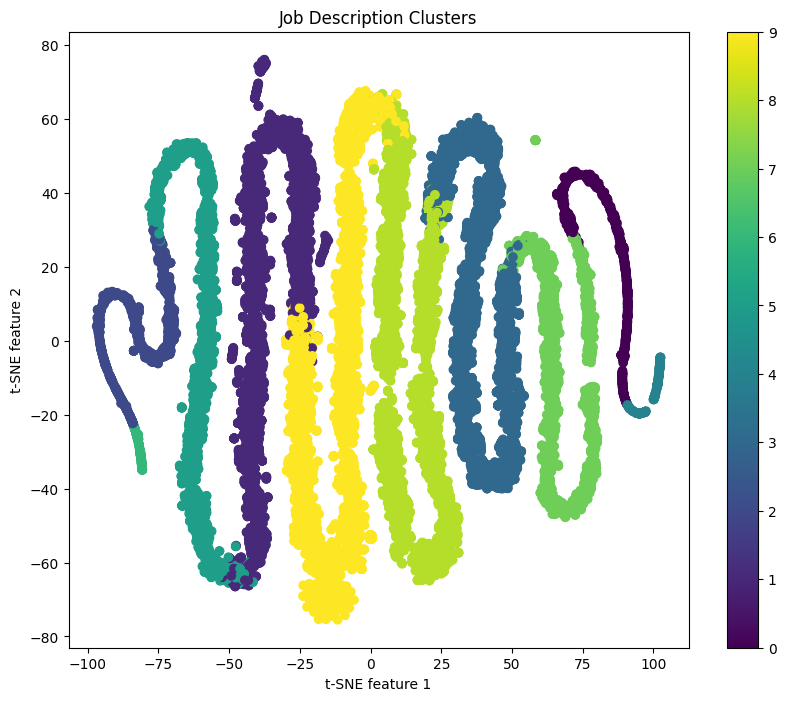

/var/folders/m0/46jgs1hd0lvg8pn1fr_jwhrc0000gn/T/ipykernel_20099/654092556.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], cmap='viridis')


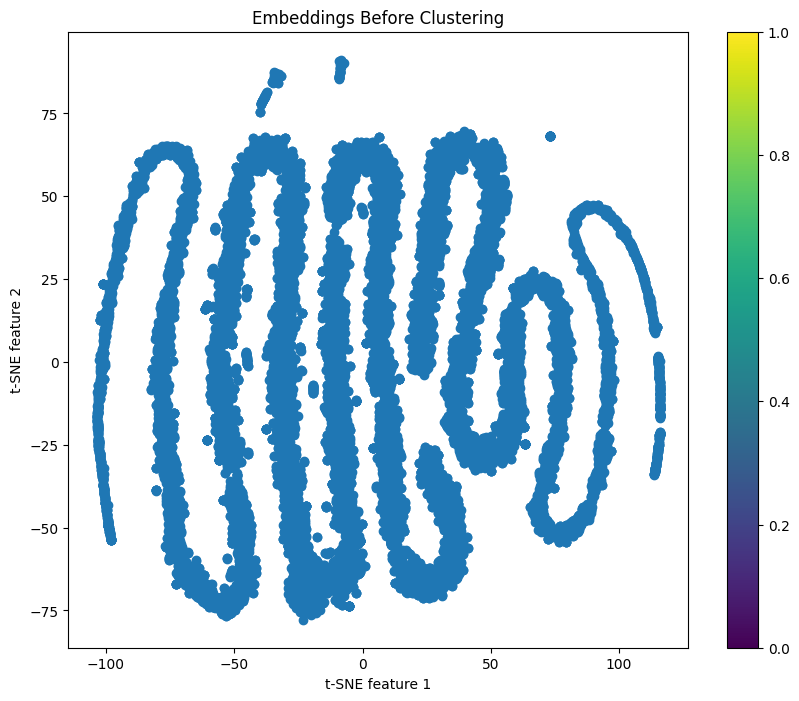

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_clusters(embeddings, labels, perplexity=30, learning_rate=200, n_iter=1000):
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Job Description Clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

# Reduce dimensionality before t-SNE
reduced_embeddings = reduce_dimensionality(embeddings, n_components=50)

# Visualize the clusters
visualize_clusters(reduced_embeddings, cluster_labels)


# Visualize embeddings before clustering
def visualize_embeddings(embeddings, title='Embeddings'):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

# Visualize embeddings before clustering
visualize_embeddings(embeddings, title='Embeddings Before Clustering')

## Suggesting Job Cluster Titles

In [15]:
from nltk.corpus import stopwords
from collections import Counter # Import Counter for word frequency counting

def suggest_cluster_titles(df, text_column, cluster_column, n_words=5):
    stop_words = set(stopwords.words('english'))
    cluster_titles = {}
    
    for cluster in df[cluster_column].unique():
        cluster_texts = df[df[cluster_column] == cluster][text_column]
        words = ' '.join(cluster_texts).lower().split()
        word_counts = Counter(word for word in words if word not in stop_words and len(word) > 3)
        top_words = [word for word, _ in word_counts.most_common(n_words)]
        cluster_titles[cluster] = ' '.join(top_words)
    
    return cluster_titles

# Suggest titles for each cluster
cluster_titles = suggest_cluster_titles(df, 'Extracted_Description', 'Cluster')

# Print suggested titles
for cluster, title in cluster_titles.items():
    print(f"Cluster {cluster}: {title}")

# Add suggested titles to the dataframe
df['Suggested_Title'] = df['Cluster'].map(cluster_titles)

# Display a few examples
print(df[['Cluster', 'Suggested_Title', 'OrigJobTitle']].head(10))

Cluster 8: work engineering support technical design
Cluster 0: work team engineer engineering support
Cluster 4: team work engineer clients support
Cluster 3: work engineering systems design team
Cluster 7: work engineering systems engineer team
Cluster 9: work engineering design technical support
Cluster 1: work engineering design technical support
Cluster 5: engineering work project design technical
Cluster 2: engineering project design work technical
Cluster 6: support engineering engineer technical provide
   Cluster                            Suggested_Title  \
0        8  work engineering support technical design   
1        0     work team engineer engineering support   
2        4         team work engineer clients support   
3        8  work engineering support technical design   
4        3       work engineering systems design team   
5        0     work team engineer engineering support   
6        0     work team engineer engineering support   
7        3       work engin